In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import glob
from PIL import Image
all_images = []
labels = []
img_size=(32, 20)
for f in glob.glob('c:\\data\\power\\**\\*.jpg', recursive=True):
    arr = f.split('\\')
    img = Image.open(f)
    img_resize = img.resize((img_size[0], img_size[1]))
    all_images.append(img_resize)
    label= float(arr[3])
    labels.append(label)

In [3]:
labels[:10]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [4]:
len(labels)

12319

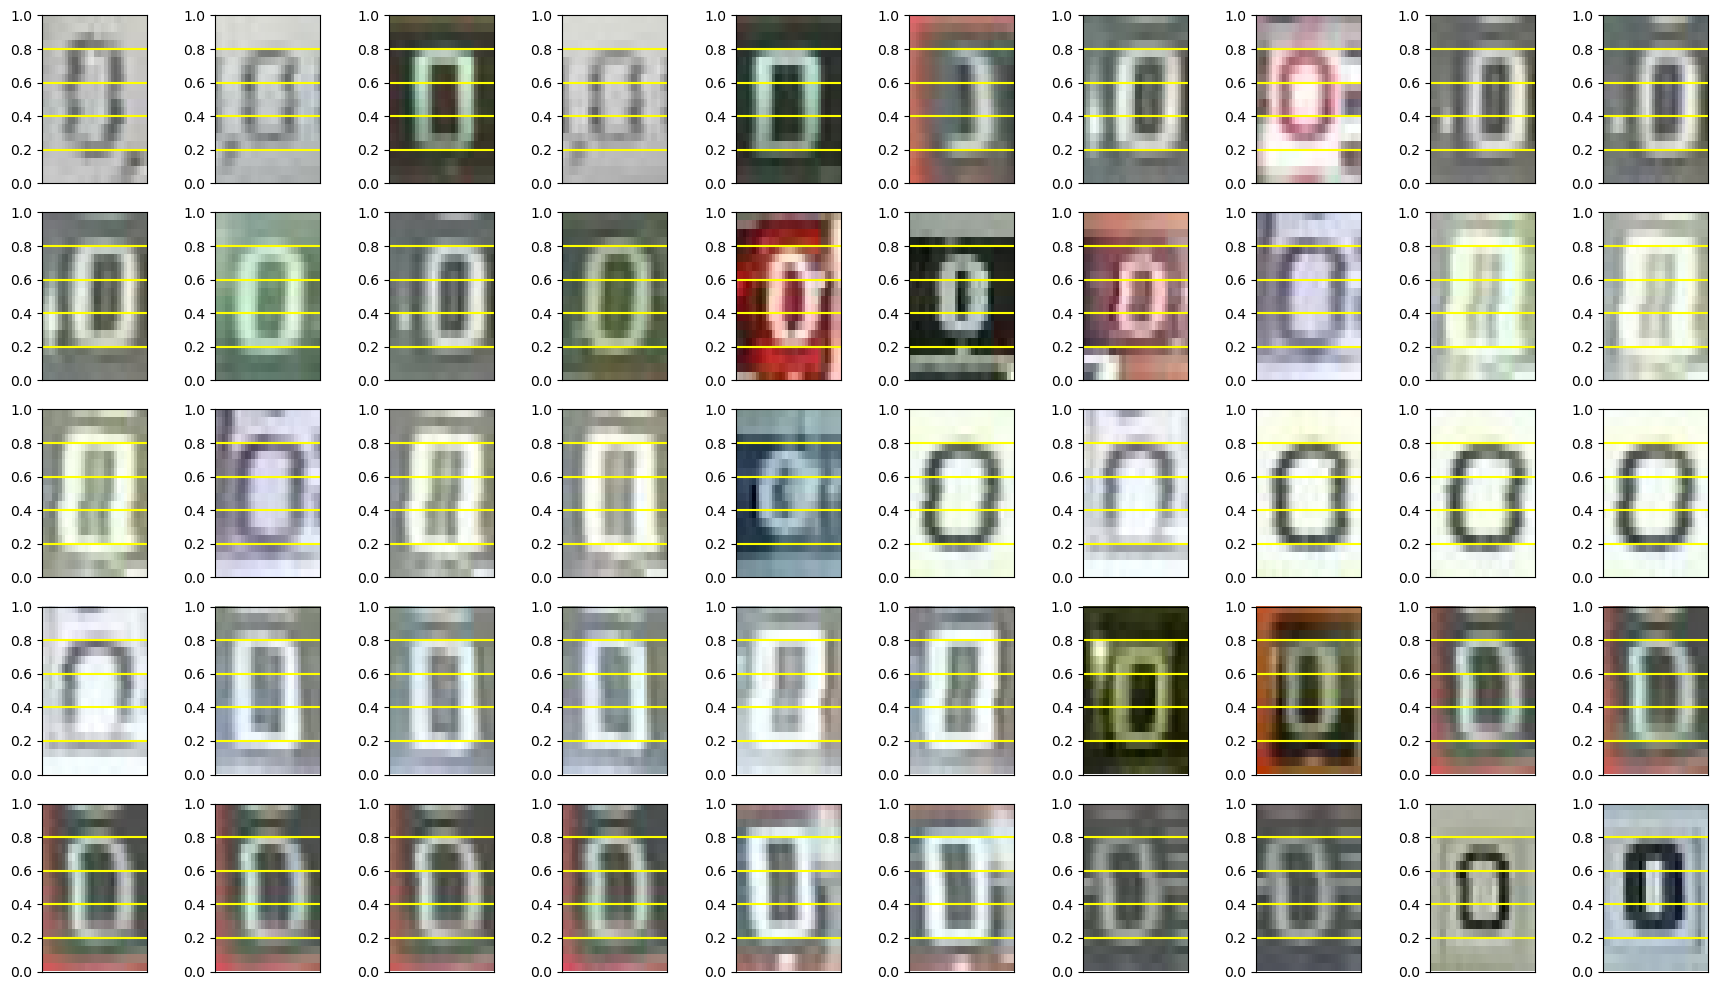

In [5]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(18, 10))
columns = 10
rows = 5
for i in range(1, columns*rows+1):
    if i > len(all_images):
        break
    fig.add_subplot(rows, columns, i)
    plt.xticks([0.2, 0.4, 0.6, 0.8])
    plt.imshow((all_images[i-1]), aspect='1.6', extent=[0, 1, 0, 1])
    for y in np.arange(0.2, 0.8, 0.2):
        plt.axhline(y=y, color='yellow')
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    plt.tight_layout()
plt.show()

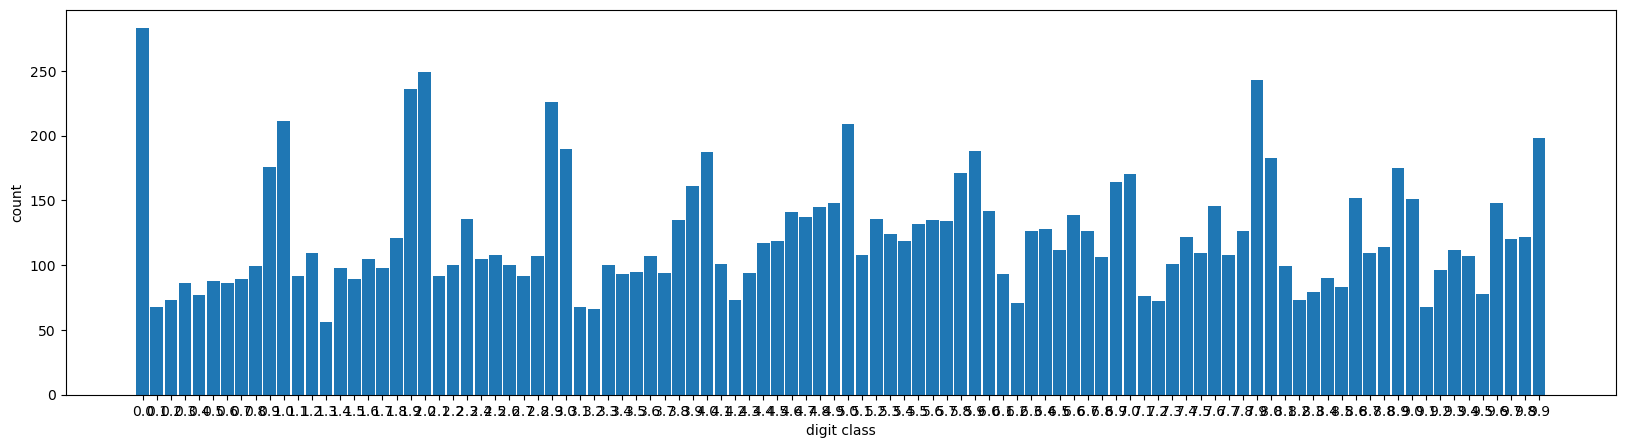

In [6]:
_, inverse = np.unique(labels, return_inverse=True)
data_bincount = np.bincount(inverse)
plt.figure(figsize=(20,5))
plt.bar(np.arange (0, 10, 0.1), data_bincount, width=0.09, align='center')
plt.ylabel('count')
plt.xlabel('digit class')
plt.xticks(np.arange(0, 10, 0.1))
plt.show()

In [7]:
X = np.empty((1, img_size[0], img_size[1], 3))
for img in all_images:
    X = np.vstack((X, np.array(img).reshape(1, img_size[0], img_size[1], 3)))
X.shape

(12320, 32, 20, 3)

In [8]:
X = np.delete(X, (0), axis=0)

In [9]:
X.shape

(12319, 32, 20, 3)

In [ ]:
X_data = X / 255.

In [ ]:
y_data = np.array(labels)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2,
                                                    shuffle=True, random_state=10)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9855, 32, 20, 3), (2464, 32, 20, 3), (9855,), (2464,))

In [20]:
from keras.models import Sequential
from keras.layers import *
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3))) # 미니 배치의 출력값 정규화
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.1))
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.1))
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation=None))
model.compile(loss='mae', optimizer='rmsprop', metrics=['mae'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 32, 20, 3)        12        
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 20, 32)        896       
                                                                 
 batch_normalization_5 (Batc  (None, 32, 20, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 10, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 16, 10, 32)        0         
                                                      

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('c:/data/model/power_best.h5', monitor='val_loss', 
                             verbose=1, save_best_only=True, mode='min')
hist = model.fit(X_train, y_train, batch_size=32, validation_split=0.2, epochs=100, callbacks=[checkpoint])

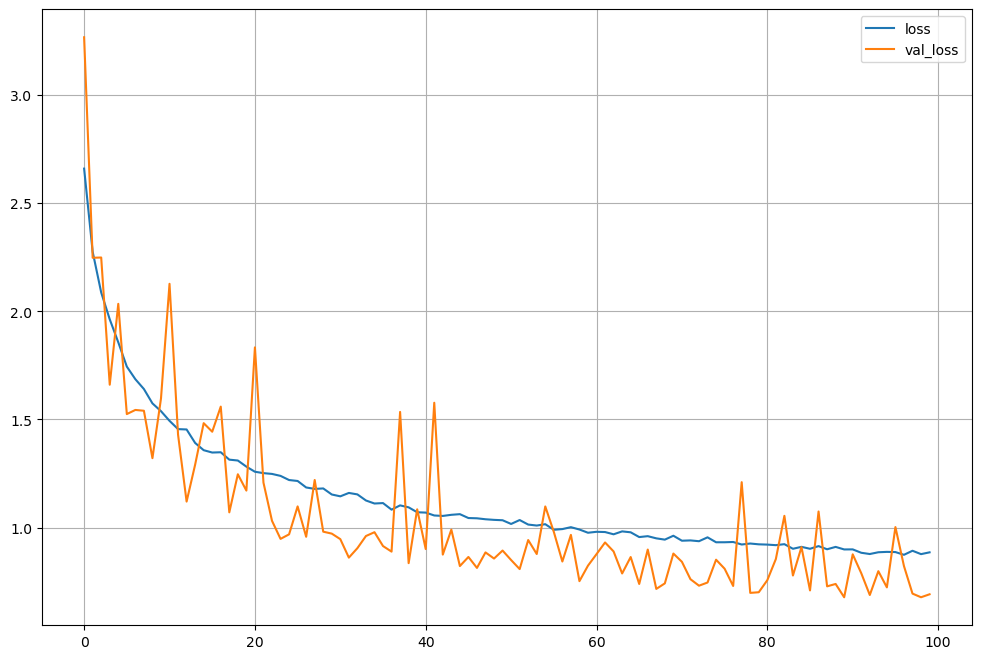

In [22]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.grid()
plt.show()

In [16]:
from tensorflow.keras.models import load_model
model = load_model('c:/data/model/power_best.h5')
scores = model.evaluate(X_train, y_train, verbose=1)
print(scores)

308/308 [==============================] - 1s 3ms/step - loss: 0.5207 - mae: 0.5207
[0.5207045078277588, 0.5207045078277588]


In [17]:
scores = model.evaluate(X_test, y_test, verbose=1)
print(scores)

77/77 [==============================] - 0s 3ms/step - loss: 0.6522 - mae: 0.6522
[0.6521610021591187, 0.6521610021591187]


In [18]:
pred = model.predict(X_test)
pred[:5]

77/77 [==============================] - 0s 2ms/step


array([[ 5.145297 ],
       [ 8.2941475],
       [ 3.991136 ],
       [ 4.962804 ],
       [-0.3269391]], dtype=float32)

In [19]:
y_test[:5]

array([5.8, 8.1, 4. , 8. , 0.2])